<a href="https://colab.research.google.com/github/zw2497/Neural_Network_PDE/blob/master/ODE1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip -q install tf-nightly-2.0-preview

     |████████████████████████████████| 87.1MB 1.2MB/s 
     |████████████████████████████████| 430kB 43.2MB/s 
     |████████████████████████████████| 61kB 22.0MB/s 
     |████████████████████████████████| 3.1MB 48.9MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


In [0]:
import tensorflow as tf 
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
%matplotlib inline


In [0]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.nn import relu

In [4]:
print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-dev20190501


In [0]:
nx = 10
dx = 1. / nx

In [0]:
def A(x):
    '''
        Left part of initial equation
    '''
    return x + (1. + 3.*x**2) / (1. + x + x**3)


def B(x):
    '''
        Right part of initial equation
    '''
    return x**3 + 2.*x + x**2 * ((1. + 3.*x**2) / (1. + x + x**3))


def f(x, psy):
    '''
        d(psy)/dx = f(x, psy)
        This is f() function on the right
    '''
    return B(x) - psy * A(x)


def psy_analytic(x):
    '''
        Analytical solution of current problem
    '''
    return (np.exp((-x**2)/2.)) / (1. + x + x**3) + x**2

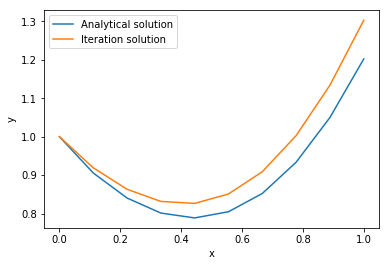

In [19]:
x_space = np.linspace(0, 1, nx)    
y_space = psy_analytic(x_space)
psy_fd = np.zeros_like(y_space)
psy_fd[0] = 1. # IC

for i in range(1, len(x_space)):
    psy_fd[i] = psy_fd[i-1] + B(x_space[i]) * dx - psy_fd[i-1] * A(x_space[i]) * dx

plt.figure()
plt.plot(x_space, y_space) 
plt.plot(x_space, psy_fd)
plt.legend(["Analytical solution","Iteration solution"])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Build Neural Network

In [0]:
def loss_function(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred)

In [0]:
class MyModel(Model):
    def __init__(self):
        super(Model, self).__init__()
        self.d1 = Dense(10, activation='relu')
        self.d2 = Dense(1)

    def call(self, x):
        x = self.d1(x)
        return self.d2(x)

model = MyModel()
optimizer = tf.keras.optimizers.Adam()

In [0]:
x_space = np.linspace(0, 1, 10).astype('float64').reshape(10,1)
x_space = tf.constant(x_space)

In [11]:
def train_on_batch(x):
    with tf.GradientTape() as tape:
        with tf.GradientTape() as g:
            g.watch(x)
            net_out = model(x)
            psy_t = 1 + x * net_out
        d_psy_t = g.gradient(psy_t, x)
        
        y_predict = B(x) - psy_t * A(x)
        loss = loss_function(B(x) - psy_t * A(x), d_psy_t)
        
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    return loss
train_on_batch(x_space)

<tf.Tensor: id=159, shape=(10,), dtype=float64, numpy=
array([1.        , 0.95946811, 1.03481429, 1.17963597, 1.35310894,
       1.51162588, 1.61297261, 1.62506833, 1.53293531, 1.34087145])>

In [0]:
for _ in range(1000):
    train_on_batch(x_space)

In [0]:
test = np.array([[2.0], [3.0]]).astype('float64')
test = tf.constant(test)

In [14]:
test = np.array([[2.0]]).astype('float64')
test = tf.constant(test)
with tf.GradientTape() as tape:
    tape.watch(test)
    net_out = model(test)
    print(type(test), type(net_out))
    psy_t = 1 + tf.math.multiply(test, net_out)
tape.gradient(psy_t, test)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


<tf.Tensor: id=267468, shape=(1, 1), dtype=float64, numpy=array([[3.57554138]])>

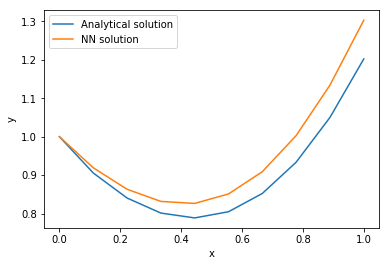

In [15]:
x_space = np.linspace(0, 1, nx)    
y_space = psy_analytic(x_space)
psy_fd = np.zeros_like(y_space)
psy_fd[0] = 1. # IC

for i in range(1, len(x_space)):
    psy_fd[i] = psy_fd[i-1] + B(x_space[i]) * dx - psy_fd[i-1] * A(x_space[i]) * dx
  
plt.figure()
plt.plot(x_space, y_space) 
plt.plot(x_space, psy_fd)
plt.legend(["Analytical solution","NN solution"])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [16]:
x_space

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [17]:
for xi in x_space:
    tt = model(np.array(xi).reshape(1,1))
    print(tt.numpy())

[[-0.59679793]]
[[-0.6004909]]
[[-0.60418386]]
[[-0.53082425]]
[[-0.40638892]]
[[-0.2819536]]
[[-0.15751828]]
[[-0.03308296]]
[[0.09135236]]
[[0.21578769]]


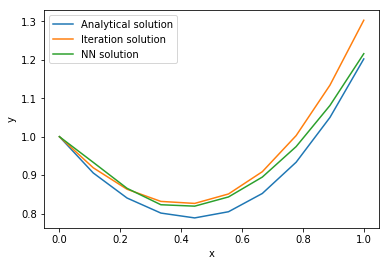

In [18]:
res = [1 + xi * model(np.array(xi).reshape(1,1))[0][0] for xi in x_space] 

plt.figure()
plt.plot(x_space, y_space) 
plt.plot(x_space, psy_fd)
plt.plot(x_space, res)
plt.legend(["Analytical solution","Iteration solution","NN solution"])
plt.xlabel("x")
plt.ylabel("y")
plt.show()